<div style="position: relative;">
<img src="https://user-images.githubusercontent.com/7065401/98728503-5ab82f80-2378-11eb-9c79-adeb308fc647.png"></img>

<h1 style="color: white; position: absolute; top:27%; left:10%;">
     Secure RESTful APIs using Python
</h1>

<h3 style="color: #ef7d22; font-weight: normal; position: absolute; top:56%; left:10%;">
    David Mertz, Ph.D.
</h3>

<h3 style="color: #ef7d22; font-weight: normal; position: absolute; top:63%; left:10%;">
    Data Scientist
</h3>
</div>

# Serialization formats

In the web services or micro-services we have constructed so far, data has been returned in several formats.  These were indicated by their media types (formerly known as "MIME types") in the responses.  We will see in this lesson that we can use other types than those shown; and also how it can be useful to specify a media type of data being POST'ed to services; not only for responses received.

### Common formats received

For example, let us look again at a slightly modified version of the server written for lesson one.  I show the entire script here since it illustrates a few constructs we did not use in lesson two.

To launch this, we have included a block to run it as an executable rather than via the `flask` command:

```bash
./app1.py
```

The entire server, with multiple routes, looks like the below.

```python
#!/usr/bin/env python
from flask import Flask, request, send_file, jsonify, abort
app = Flask(__name__)

@app.route('/')
def root():
    page = """<html><body><table>
        <tr><th>Path</th><th>Parameters</th></tr>
        <tr><td>/text</td><td>N/A</td></tr>
        <tr><td>/image</td><td>JPEG filename</td></tr>
        <tr><td>/json</td><td>Echo all</td></tr>
    </table></body></html>
    """
    r = make_response(page)
    r.mimetype = 'text/html'
    r.headers['X-INE-Course'] = "RESTful APIs"
    return r

@app.route('/text')
def text():
    r = make_response("Hello student!")
    r.mimetype = 'text/plain'
    return r

@app.route('/image')
def image():
    default = 'rainbow-butterfly-unicorn-kitten'
    fname = f"{request.args.get('name', default)}.jpg"
    try:
        return send_file(fname, mimetype='image/jpeg')
    except:
        abort(404)
        
@app.route('/json', methods=["GET", "POST", "PUT"])
def json():
    if request.method in {"PUT", "POST"}: 
        resp = dict(request.form)
    else:
        resp = dict(request.args)
    resp['Server'] = "Test Server #1"
    return jsonify(resp)

if __name__ == '__main__':
      # Expose to all external-facing IP addresses
      app.run(host='0.0.0.0', port=2525)
```

As we did in lesson one, let us call this service with a few different routes.

In [1]:
from IPython.display import Image, HTML
import json
import requests

r = requests.get(f'http://localhost:2525/text')
print(r.headers['Content-Type'])
r.text

text/plain; charset=utf-8


'Hello student!'

In this route, we manually set the `.mimetype` attribute on the response before returning it.  Similarly, for other routes:

In [2]:
r = requests.get(f'http://localhost:2525/json')
print(r.headers['Content-Type'])
json.loads(r.text)

application/json


{'Server': 'Test Server #1'}

Notice that in the Flask code, returning something wrapped in `jsonify()` sets the Content-Type automatically.  Likewise, if we use the `send_file()` function to wrap the response content, it gives us a chance to set a mimetype appropriately.

image/jpeg


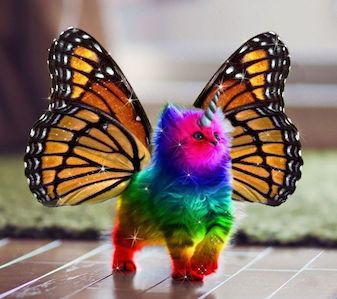

In [3]:
r = requests.get(f'http://localhost:2525/image')
print(r.headers['Content-Type'])
Image(r.content)

## Additional formats

There are thousands of media/MIME types defined by the IANA.  You can browse through them at:

> https://www.iana.org/assignments/media-types/media-types.xhtml

These fall into a few broad categories in the first part of the type.  For example: `text`, `image`, `application`, `video`.  Within each major type, there are many specialized subtypes.  

You might upload some bytes representing UTF-8 text, but the clients or servers might process it very differently if it were `text/csv`, versus `text/rtf`, versus `text/xml`.  JSON is a special type in the sense that you might assume it belongs in the `text/` general type—JSON is indeed a textual format—but because it is so widely used for general exchange of structured data, it is categorized as `application/json`.

Some subtypes are not public standards, but rather are created by particular vendors who wish to register a type.  This does not necessarily mean the format is proprietary, merely that it is associated with and determined by a project or a company rather than by standards.  When these types are named, they are given the prefix `vnd.`, such as `text/vnd.curl`, `text/vnd.graphviz`, or `text/vnd.debian.copyright`.

Generally, if you are sending binary data, it will be in some format registered with IANA.  Technically, micro-services and clients are free to use arbitrary content types.  For example, I could write a micro-service that received or sent `application/vnd.ine.mertz.data` in the `Content-Type` header.  This might be useful for an in-house service, but will obviously not be known generically by possible consumers of the data.

A special binary type is completely generic, called `application/octet-stream`.  If you are transmitting binary data but do not want the request or response to give any more specific description of the meaning of the data, this is the type to use.

## Server sensitive to Content-Type

Let's look at a service that will behave differently—but in a related way—depending on the kind of data the client puts in a request.  This toy example will count the number of times the word "butterfly" occurs in a document, but the document may also be one of several types that need to be decoded to process.  This service will run simultaneously with the one we launched above; it will use a different port, but when implemented in production might live on an entirely different server or cluster.


```python
#!/usr/bin/env python
from flask import Flask, request, jsonify, abort
from bs4 import BeautifulSoup
from striprtf.striprtf import rtf_to_text
app = Flask(__name__)

@app.route('/count-butterflies', methods=["POST"])
def butterfly():
    "Count how many times the word 'butterfly' appears in document"
    document = request.data.decode()  # Make bytes into text
    if request.content_type == 'text/plain':
        text, decoder = document, None
    elif request.content_type == 'text/html':
        soup = BeautifulSoup(document)
        text, decoder = soup.text, "BeautifulSoup"
    elif request.content_type == 'text/rtf':
        text, decoder = rtf_to_text(document), "striprtf"
    else:
        abort(400)  # 400 Bad Request

    count = text.lower().count('butterfly')
    return jsonify({"count": count, "decoder": decoder})

if __name__ == '__main__':
      # Expose to all external-facing IP addresses
      app.run(host='0.0.0.0', port=2526)
```

Let's open up a few different kinds of documents that we might want to use with this service.  All of these are versions of the 1922 book <u>Butterflies Worth Knowing</u>, by Clarence Moores Weed (https://www.gutenberg.org/ebooks/37009).  The plain text and HTML versions I downloaded directly, the RTF version I created myself based on the HTML.  We can see that all are *textual* but not all plain text.

In [4]:
htm  = open('37009.html').read()
print(htm[:160])

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN"
        "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">
  <html xmlns="http://www.w3.org/1999/xhtm


In [5]:
rtf = open('37009.rtf').read()
print(rtf[:160])

{\rtf1\ansi\deff3\adeflang1025
{\fonttbl{\f0\froman\fprq2\fcharset0 Times New Roman;}{\f1\froman\fprq2\fcharset2 Symbol;}{\f2\fswiss\fprq2\fcharset0 Arial;}{\f3


In [6]:
txt = open('pg37009.txt').read()
print(txt[:160])

﻿The Project Gutenberg EBook of Butterflies Worth Knowing, by Clarence M. Weed

This eBook is for the use of anyone anywhere at no cost and with
almost no restr


### Calling the service

We might try calling the service with a little bit of binary text.  Communication with the server always transmits binary data, even if it is intended to represent text.

In [7]:
url = 'http://localhost:2526/count-butterflies'
r = requests.post(url, data=b'Rainbow butterfly unicorn kitten')
print(r.status_code)
HTML(r.text)

400


No Content-Type was specified, so the server simply has a `None` for that attribute of the `request` object.  Let's improve that.

In [8]:
r = requests.post(url, data=b'Rainbow butterfly unicorn kitten', 
                  headers={'Content-Type': 'text/plain'})
json.loads(r.text)

{'count': 1, 'decoder': None}

This worked for our short fragment of text.  We can try sending the longer documents.  Notice that we need to `.encode()` the texts as binary before attaching them to the request.  We could also have simply opened and read their content as binary to start with instead.

In [9]:
r = requests.post(url, data=txt.encode(), 
                  headers={'Content-Type': 'text/plain'})
json.loads(r.text)

{'count': 443, 'decoder': None}

In [10]:
r = requests.post(url, data=htm.encode(), 
                  headers={'Content-Type': 'text/html'})
json.loads(r.text)

{'count': 443, 'decoder': 'BeautifulSoup'}

In [11]:
r = requests.post(url, data=rtf.encode(), 
                  headers={'Content-Type': 'text/rtf'})
json.loads(r.text)

{'count': 426, 'decoder': 'striprtf'}

Something seems to be flawed either in my conversion of the document to RTF or in the `striprtf` library.  In any case, we see that we get a different (wrong) answer if we attempt to interpret it as a different format.

In [12]:
r = requests.post(url, data=rtf.encode(), 
                  headers={'Content-Type': 'text/html'})
json.loads(r.text)

{'count': 464, 'decoder': 'BeautifulSoup'}

## Custom binary data

Sometimes the data we wish to work with does not fit neatly into a MIME type.  For example, NumPy arrays are structures we often work with in data science and numeric computing.  Perhaps we would like a micro-service to process these somehow.  Let's create one for the examples.

In [13]:
import pickle
import io
import numpy as np
arr = np.random.normal(size=(2, 3, 4))
arr

array([[[-4.53879612e-01, -1.20238161e-01,  3.32807938e-01,
          8.29206683e-01],
        [-8.86202538e-01, -9.83094473e-01,  4.35270615e-01,
         -2.50496716e-04],
        [ 2.98945953e-01, -1.46946416e+00,  4.71350782e-01,
          1.65400848e+00]],

       [[ 6.91987692e-02, -4.74830049e-02,  2.83464677e-01,
         -8.10212375e-01],
        [ 1.61068829e+00,  4.70331137e-01, -2.10871517e+00,
         -1.18218160e+00],
        [ 1.23056547e+00,  1.16829516e+00, -2.97901302e-01,
         -4.22274897e-01]]])

The quandary here is that although we wish to process data in this efficient format, it is very Python-specific.  A web-service that utilizes NumPy arrays as such will not be able to talk with clients—or other micro-services—that are written in other programming languages.

A common approach is to serialize the data into a more generic format, such as `application/json`, at one end, then deserialize it back to NumPy at the other end.  However, this adds time overhead in the format conversion, potentially loses some metadata or other features, and might result in larger payloads.  Moreover, such conversions are likely to require a certain amount of custom code to perform (for example, `json.dumps()` will not directly handle a NumPy array).

For purpose of the following example, we assume that you are happy with a Python-centric approach to your micro-services.  We can serialize NumPy arrays in a couple ways that are very efficient.  The function `numpy.save()` is very efficient. It adds a short header, but in the main simply directly copies the in-memory layout of bytes.  Using Python `pickle` is very similar in this case, since the bulk of what is saved is simply the NumPy serialization format, with somewhat larger header metadata.  Let's take a look.

In [14]:
buffer = io.BytesIO()
np.save(buffer, arr)
npy = buffer.getvalue()
npy[:80]

b"\x93NUMPY\x01\x00v\x00{'descr': '<f8', 'fortran_order': False, 'shape': (2, 3, 4), }        "

In [15]:
pkl = pickle.dumps(arr)
pkl[:80]

b'\x80\x04\x95L\x01\x00\x00\x00\x00\x00\x00\x8c\x15numpy.core.multiarray\x94\x8c\x0c_reconstruct\x94\x93\x94\x8c\x05numpy\x94\x8c\x07ndarray\x94\x93\x94K\x00\x85\x94C\x01b\x94'

### Sending the data

The server or micro-service that processes these formats is very similar to ones we have seen.  It is running on a different port than the prior two (which are also still running).

```python
#!/usr/bin/env python
import numpy as np
import pickle, io
from flask import Flask, request, abort, make_response
app = Flask(__name__)

@app.route('/add100', methods=["POST"])
def add100():
    if (request.content_type == 'application/octet-stream' 
            and request.headers['X-INE-type'] == "pickle"):
        arr = pickle.loads(request.data)
        arr += 100
        resp = make_response(pickle.dumps(arr))
        resp.mimetype = 'application/octet-stream'
        resp.headers['X-INE-type'] = "pickle"
        return resp
    elif request.content_type == 'application/vnd.ine.numpy':
        arr = np.load(io.BytesIO(request.data))
        arr += 100
        buffer = io.BytesIO()
        np.save(buffer, arr)
        resp = make_response(buffer.getvalue())
        resp.mimetype = 'application/vnd.ine.numpy'
        return resp        
    else:
        abort(400)  # 400 Bad Request

if __name__ == '__main__':
      # Expose to all external-facing IP addresses
      app.run(host='0.0.0.0', port=2527)
```

In [16]:
url = 'http://localhost:2527/add100'
r = requests.post(url, data=npy, 
                  headers={'Content-Type': 'application/vnd.ine.numpy'})
np.load(io.BytesIO(r.content))

array([[[ 99.54612039,  99.87976184, 100.33280794, 100.82920668],
        [ 99.11379746,  99.01690553, 100.43527062,  99.9997495 ],
        [100.29894595,  98.53053584, 100.47135078, 101.65400848]],

       [[100.06919877,  99.952517  , 100.28346468,  99.18978763],
        [101.61068829, 100.47033114,  97.89128483,  98.8178184 ],
        [101.23056547, 101.16829516,  99.7020987 ,  99.5777251 ]]])

In [17]:
headers = {'Content-Type': 'application/octet-stream', 
           'X-INE-type': 'pickle'}
r = requests.post(url, data=pkl, headers=headers)
pickle.loads(r.content)

array([[[ 99.54612039,  99.87976184, 100.33280794, 100.82920668],
        [ 99.11379746,  99.01690553, 100.43527062,  99.9997495 ],
        [100.29894595,  98.53053584, 100.47135078, 101.65400848]],

       [[100.06919877,  99.952517  , 100.28346468,  99.18978763],
        [101.61068829, 100.47033114,  97.89128483,  98.8178184 ],
        [101.23056547, 101.16829516,  99.7020987 ,  99.5777251 ]]])